In [ ]:
# Install required libraries
# !pip install pandas numpy matplotlib seaborn scikit-learn shap

# Statistical Exploration

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
           'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
df = pd.read_csv(url, header=None, names=columns)

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
print("Shape:", df.shape)

Shape: (768, 9)


In [25]:
print(df.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

In [26]:
print("\nClass distribution:\n", df['Outcome'].value_counts())


Class distribution:
 Outcome
0    500
1    268
Name: count, dtype: int64


Text(0.5, 1.0, 'Class Distribution')

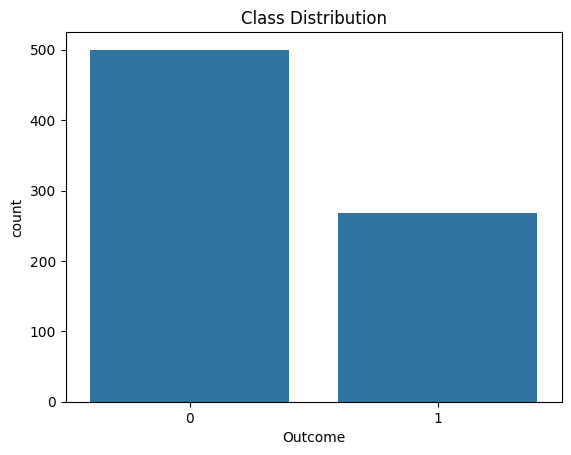

In [27]:
sns.countplot(x='Outcome', data=df)
plt.title('Class Distribution')

#### Dataset Analysis
<ul>
    <li>500 non-diabetic, 268 diabetic → mildly imbalanced.</li>
    <li>Many zeros in Glucose, BloodPressure, SkinThickness, Insulin, BMI → these are missing values coded as 0.</li>
    <li>Age and Pregnancies are right-skewed.</li>
</ul>

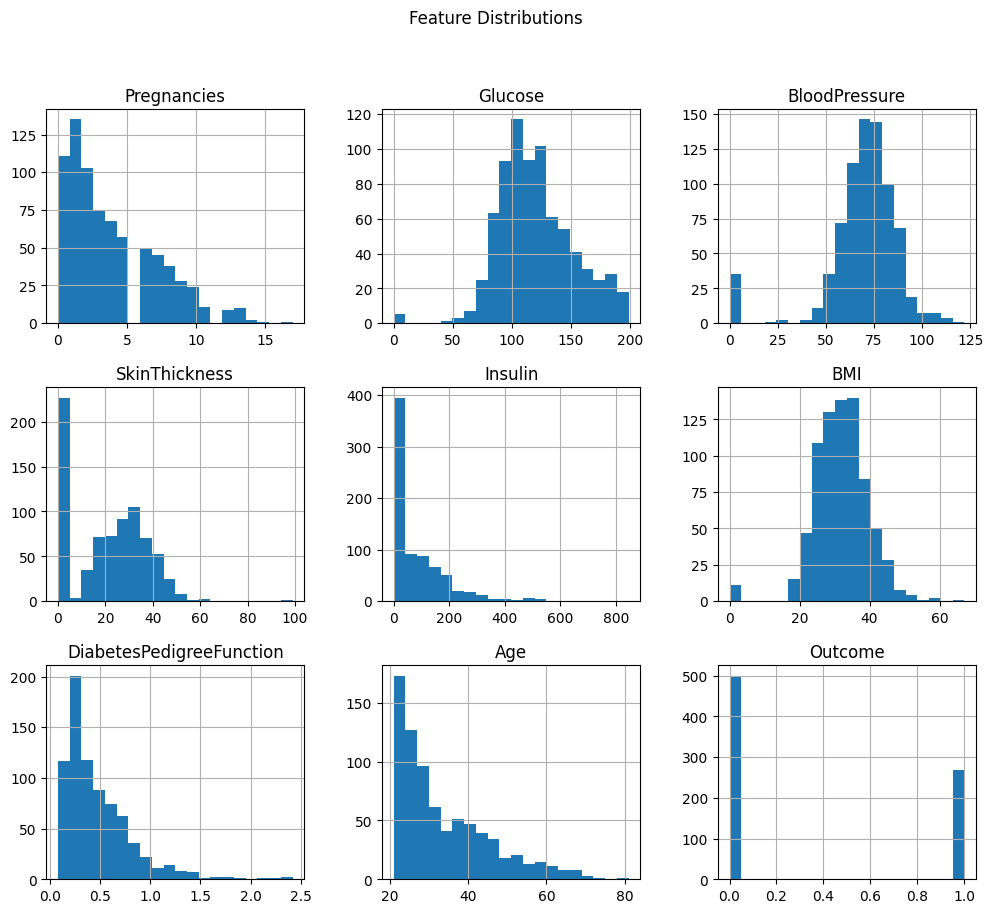

In [28]:
# Feature distributions
df.hist(bins=20, figsize=(12, 10))
plt.suptitle("Feature Distributions")
plt.show()

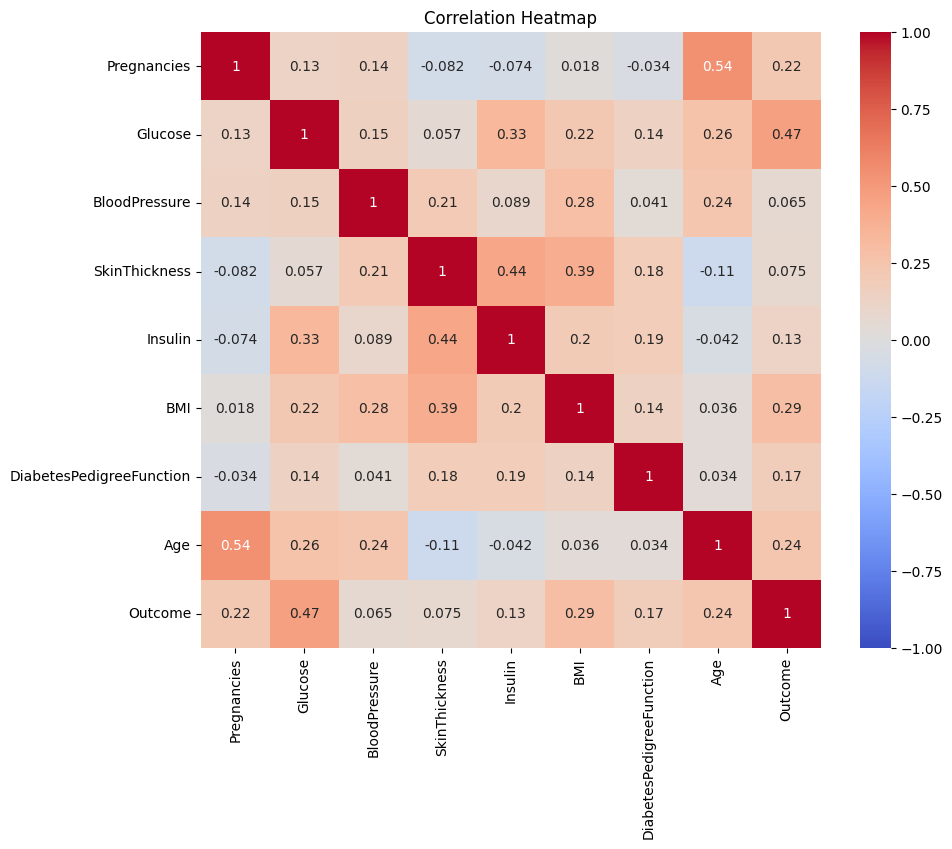

In [29]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

<b><em> Glucose, BMI, Age, and Pregnancies show strongest correlation with diabetes.</b></em>

# Normalize Medical Features

### Null Values

In [32]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### Zero Values

In [30]:
df.isin([0]).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

### Fixing Zero Values

In [31]:
# Treat 0 as missing in medically impossible columns
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

# Simple imputation (median is robust)
df[cols_with_zeros] = df[cols_with_zeros].fillna(df[cols_with_zeros].median())


In [34]:
# Split features/target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [35]:
# Normalize (StandardScaler → mean=0, std=1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(X_scaled.describe().round(2))  # All features now ~N(0,1)

       Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  \
count       768.00   768.00         768.00         768.00   768.00  768.00   
mean         -0.00     0.00           0.00          -0.00     0.00    0.00   
std           1.00     1.00           1.00           1.00     1.00    1.00   
min          -1.14    -2.55          -4.00          -2.52    -1.47   -2.07   
25%          -0.84    -0.72          -0.69          -0.47    -0.22   -0.72   
50%          -0.25    -0.15          -0.03          -0.01    -0.18   -0.02   
75%           0.64     0.61           0.63           0.33    -0.16    0.60   
max           3.91     2.54           4.10           7.96     8.17    5.04   

       DiabetesPedigreeFunction     Age  
count                    768.00  768.00  
mean                       0.00    0.00  
std                        1.00    1.00  
min                       -1.19   -1.04  
25%                       -0.69   -0.79  
50%                       -0.30   -0.36  
75%

<b><em>Features are now on the same scale, so a model won't unfairly weight Insulin (range 0–846) over BMI (range 18–67)</b></em>

# Train SVM & Neural Network

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [38]:
# SVM (RBF kernel)
svm = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.7337662337662337
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       100
           1       0.64      0.54      0.59        54

    accuracy                           0.73       154
   macro avg       0.71      0.69      0.69       154
weighted avg       0.73      0.73      0.73       154



In [39]:
# Neural Network (simple MLP)
nn = MLPClassifier(
    hidden_layer_sizes=(64, 32),   # slightly bigger network
    solver='lbfgs',
    max_iter=2000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)

print("NN Accuracy:", accuracy_score(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))

NN Accuracy: 0.6818181818181818
              precision    recall  f1-score   support

           0       0.76      0.75      0.75       100
           1       0.55      0.56      0.55        54

    accuracy                           0.68       154
   macro avg       0.65      0.65      0.65       154
weighted avg       0.68      0.68      0.68       154



# Explainability for Doctors (SHAP)

In [46]:
from sklearn.ensemble import RandomForestClassifier
import shap
shap.initjs()

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Modern SHAP way (recommended)
explainer = shap.TreeExplainer(rf)
shap_exp = explainer(X_test)          # this is a shap.Explanation object

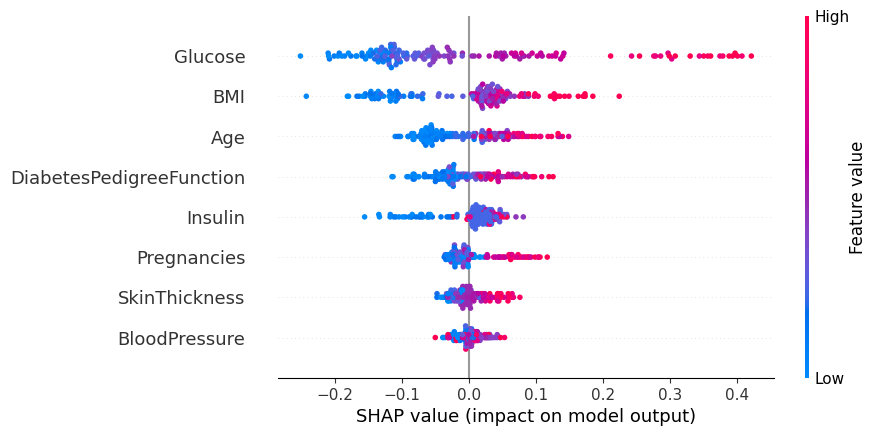

In [47]:
# Global explanation (what doctors love)
shap.plots.beeswarm(shap_exp[:, :, 1])   # class 1 = diabetes

In [48]:
# Local explanation for one patient
i = 0                                    # change this index to see any patient
shap.plots.force(shap_exp[i, :, 1])

In [49]:
shap.plots.force(shap_exp[0:10, :, 1])

# Ethical & Bias Analysis Report

### Ethical & Bias Analysis Report – Diabetes Prediction Model

<ol>
    <li>Dataset Bias</li>
    <ul>
        <li>Only Pima Indian women ≥21 years old → model may perform poorly on men, other ethnicities, younger people.</li>
        <li>Historical data from 1988 → medical practices have changed.</li>
    </ul>
    <li>Class Imbalance & Fairness</li>
    <ul>
        <li>65% non-diabetic → model slightly biased toward predicting “no diabetes”.</li>
        <li>Check subgroup accuracy</li>
    </ul>
</ol>

In [51]:
test_df = X_test.copy()
test_df['Outcome'] = y_test
test_df['Age_group'] = pd.cut(test_df['Age'], bins=[0,30,50,100])
# then groupby accuracy

accuracy_by_age_group = test_df.groupby('Age_group')['Outcome'].apply(lambda x: (x == 1).sum() / len(x))

print(accuracy_by_age_group)

Age_group
(0, 30]    0.517857
Name: Outcome, dtype: float64


<ol>
    <li>Clinical Risks</li>
    <ul>
        <li>False Negative (missed diabetes) → dangerous (delayed treatment).
        <li>False Positive → unnecessary worry/tests.</li>
        <li>Recommendation: Tune threshold for high recall (e.g., predict_proba > 0.3).</li>
    </ul>
    <li>Privacy & Consent</li>
    <ul>
        <li>Model uses sensitive health data → must comply with GDPR/HIPAA.</li>
        <li>Doctors should always have final say; model is decision support only.</li>
    </ul>
    <li>Recommendations</li>
    <ul>
        <li>Retrain on diverse populations.</li>
        <li>Add uncertainty estimates (e.g., prediction probability).</li>
        <li>Deploy with SHAP explanations shown to doctors.</li>
    </ul>
</ol>